In [ ]:
from google.colab import files
from google.colab import drive
from google.colab.patches import cv2_imshow

from io import BytesIO

import numpy as np

import pandas as pd

import sys, os, re, csv, codecs
from os import listdir

import tensorflow as tf

import cv2

import keras
from keras import preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras import models
from keras.models import model_from_json
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils.data_utils import get_file
from keras.preprocessing.image import img_to_array
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import preprocess_input

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import skimage

import scipy
from scipy import ndimage, misc

from PIL import Image

import glob

import sklearn
from sklearn.metrics import confusion_matrix

import imutils
import torch

from imblearn.under_sampling import NearMiss
from numpy import genfromtxt
import os
from sklearn.utils import shuffle
from matplotlib import cm

In [ ]:
torch.cuda.device_count()
torch.cuda.get_device_name(0)

1

In [ ]:
tf.compat.v2
print(tf.__version__)

2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Two Classes

In [ ]:
new_root_dir_exp = '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp'

In [ ]:
def preprocessing(path, path_mu1, path_mu5):
 imgs_array = []
 label_array = []
 cartelle = [j for j in sorted(os.listdir(path))]

 for folder in cartelle:


   if folder.startswith('eco10-20%'):
     immagini_mu1 = [i for i in sorted(os.listdir(path_mu1))]
     for image in immagini_mu1:
       images = np.load(os.path.join(path_mu1, image))
       images = images.reshape(71,22,1)
       label_array.append(1)
       imgs_array.append(images) #images are added to a list

   if folder.startswith('eco30'):
     immagini_mu5 = [i for i in sorted(os.listdir(path_mu5))]
     for image in immagini_mu5:
       images = np.load(os.path.join(path_mu5, image))
       images = images.reshape(71,22,1)
       label_array.append(5)
       imgs_array.append(images) #images are added to a list



 return imgs_array, label_array

In [ ]:
from sklearn.utils import shuffle
#path_eco10_10= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10-10%'
#path_eco10= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10'
path_eco10_20= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10-20%'
path_eco30= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco30'
#preprocessing and shuffle
newarray_3, newlabel_3 = preprocessing(new_root_dir_exp,  path_eco10_20, path_eco30)
new_array_3, new_label_3 = shuffle(newarray_3,newlabel_3, random_state=24) #Random state allows to obtain the same shuffle over time

Text(0.5, 0, '5')

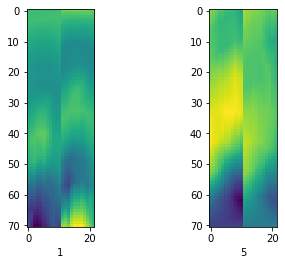

In [ ]:
plt.subplot(121)
img=np.reshape(newarray_3[1], (71, 22))
plt.imshow(img)
plt.xlabel(newlabel_3[1])

plt.subplot(122)
img=np.reshape(newarray_3[103], (71, 22))
plt.imshow(img)
plt.xlabel(newlabel_3[103])


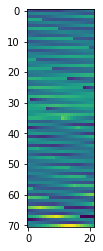

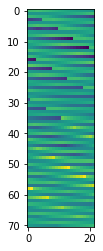

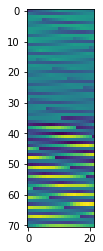

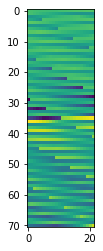

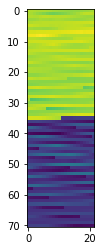

In [ ]:
for i, image in enumerate(newarray_3):
  if i<5:
    plt.figure()
    image = image.transpose((1, 2, 0))
    image=np.reshape(image, (71,22))
    plt.imshow(image)


In [ ]:
from sklearn.model_selection import train_test_split

#split in dataset in train-test
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(new_array_3,new_label_3, test_size=0.30, stratify=new_label_3, random_state=42)

#split train in train-valid
Xtrain_3, Xvalid_3, ytrain_3, yvalid_3 = train_test_split(X_train_3,y_train_3, test_size=0.30, stratify=y_train_3, random_state=42)

In [ ]:
print("Dataset Split:")
print(f"Training : {len(Xtrain_3)}")
print(f"Validation : {len(Xvalid_3)}")
print(f"Testing : {len(X_test_3)}")

Dataset Split:
Training : 50
Validation : 22
Testing : 32


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
Xtrain_3 = np.asarray(Xtrain_3)
ytrain_3 = np.asarray(ytrain_3)
ytrain_3 = ytrain_3.reshape(-1, 1)
X_test_3 = np.asarray(X_test_3)
y_test_3 = np.asarray(y_test_3)
y_test_3 = y_test_3.reshape(-1, 1)
yvalid_3 = np.asarray(yvalid_3)
yvalid_3 = yvalid_3.reshape(-1, 1)
Xvalid_3 = np.asarray(Xvalid_3)

encoder = OrdinalEncoder()
ytrain_3 = encoder.fit_transform(ytrain_3)

yvalid_3 = encoder.fit_transform(yvalid_3)

y_test_3 = encoder.fit_transform(y_test_3)


# **Data Augmentation**

In [ ]:
#This is just an example of data augmentation: there are so many functions that you can use!
import tensorflow as tf

def flip_axis(x, axis):
    cp = np.copy(x)
    cp = np.asarray(cp).swapaxes(axis, 0)
    cp = cp[::-1, ...]
    cp = cp.swapaxes(0, axis)
    return cp


def augment_data(dataset, dataset_labels, augementation_factor=2, use_flip_axis=True, use_random_rotation=True, use_random_shear=True, use_random_shift=True, use_random_brightness= True):
    augmented_image = []
    augmented_image_labels = []

    for num in range (0, dataset.shape[0]):
			# original image:
       augmented_image.append(dataset[num])
       augmented_image_labels.append(dataset_labels[num])

       for i in range(0, augementation_factor):

            # flipping
            if use_flip_axis:
                augmented_image.append(flip_axis(dataset[num],1))
                augmented_image_labels.append(dataset_labels[num])

            #random rotation
            #if use_random_rotation:
               # augmented_image.append(tf.keras.preprocessing.image.random_rotation(dataset[num], 40, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
                #augmented_image_labels.append(dataset_labels[num])
            if use_random_rotation:
                augmented_image.append(tf.keras.preprocessing.image.random_rotation(dataset[num], 150, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
                augmented_image_labels.append(dataset_labels[num])
            #random spatial shear
            if use_random_shear:
                augmented_image.append(tf.keras.preprocessing.image.random_shear(dataset[num], 0.2, row_axis=0, col_axis=1, channel_axis=0))
                augmented_image_labels.append(dataset_labels[num])
            #random spatial shift
            if use_random_shift:
                augmented_image.append(tf.keras.preprocessing.image.random_shift(dataset[num], 0.2, 0.2, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
                augmented_image_labels.append(dataset_labels[num])
            if use_random_brightness:
               augmented_image.append(tf.keras.preprocessing.image.random_brightness(dataset[num], [0.2, 0.5]))
               augmented_image_labels.append(dataset_labels[num])

    return np.array(augmented_image), np.array(augmented_image_labels)


In [ ]:
#apply data augmentation
img_augmented_3, label_augmented_3 = augment_data(Xtrain_3, ytrain_3, augementation_factor=2, use_flip_axis=True,
                                                      use_random_rotation=True, use_random_shear=True, use_random_shift=True, use_random_brightness= True)

In [ ]:
print(img_augmented_3.shape)
print(Xtrain_3.shape)

(550, 71, 22, 1)
(50, 71, 22, 1)


[0.]
[0.]


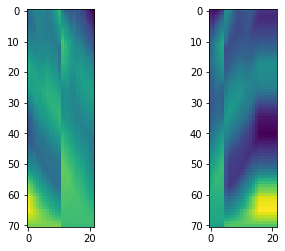

In [ ]:
plt.subplot(121)
img=np.reshape(img_augmented_3[34], (71, 22))
plt.imshow(img)
print(label_augmented_3[34])

plt.subplot(122)
img=np.reshape(img_augmented_3[35], (71, 22))
plt.imshow(img)
print(label_augmented_3[35])

##Model_3

In [ ]:
#model with 71x22 images
from keras.layers import GaussianNoise
def create_model_3():
  model = models.Sequential([

    layers.Conv2D(64, 3, activation='relu', input_shape=(71,22,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(2, activation='softmax'),
  ])
  return model

# Create a basic model instance
model_3 = create_model_3()

# Show a summary of the model. Check the number of trainable parameters
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 69, 20, 64)        640       
                                                                 
 batch_normalization_3 (Batc  (None, 69, 20, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 34, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 21760)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              22283264  
                                                                 
 dropout_4 (Dropout)         (None, 1024)             

In [ ]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.

def scheduler(num_epoch, lr):
  if num_epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
num_epochs = 30

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model_3.fit(img_augmented_3, label_augmented_3, epochs=num_epochs, batch_size=12, validation_data=(Xvalid_3, yvalid_3), verbose=1)


Epoch 1/30
46/46 [==============================] - 2s 25ms/step - loss: 2.4918 - accuracy: 0.5291 - val_loss: 0.9514 - val_accuracy: 0.5000
Epoch 2/30
46/46 [==============================] - 1s 20ms/step - loss: 2.3563 - accuracy: 0.5891 - val_loss: 1.1267 - val_accuracy: 0.5000
Epoch 3/30
46/46 [==============================] - 1s 20ms/step - loss: 2.7832 - accuracy: 0.5964 - val_loss: 0.6895 - val_accuracy: 0.5000
Epoch 4/30
46/46 [==============================] - 1s 21ms/step - loss: 1.6363 - accuracy: 0.6655 - val_loss: 0.6582 - val_accuracy: 0.5909
Epoch 5/30
46/46 [==============================] - 1s 20ms/step - loss: 2.1816 - accuracy: 0.6655 - val_loss: 0.7217 - val_accuracy: 0.5000
Epoch 6/30
46/46 [==============================] - 1s 21ms/step - loss: 1.6950 - accuracy: 0.6673 - val_loss: 0.6504 - val_accuracy: 0.5000
Epoch 7/30
46/46 [==============================] - 1s 20ms/step - loss: 1.7897 - accuracy: 0.7055 - val_loss: 0.6318 - val_accuracy: 0.6364
Epoch 8/30
46

In [ ]:
X_test_3_a = np.squeeze(X_test_3, axis=3)
print(X_test_3_a.shape)

(32, 71, 22)


              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84        16
         1.0       0.82      0.88      0.85        16

    accuracy                           0.84        32
   macro avg       0.85      0.84      0.84        32
weighted avg       0.85      0.84      0.84        32

accuracy: 0.84375
0
1


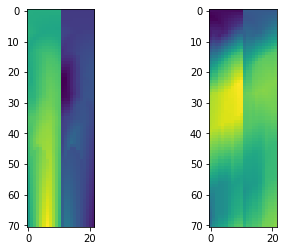

In [ ]:
#results:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#y_pred = model.predict_classes(X_test)
y_pred_3= np.argmax(model_3.predict(X_test_3),1)


print(sklearn.metrics.classification_report(y_test_3, y_pred_3))
a = accuracy_score(y_test_3, y_pred_3)
print("accuracy:",a)
plt.subplot(121)
img=np.reshape(X_test_3[20], (71, 22))
plt.imshow(img)

print(y_pred_3[20])
plt.subplot(122)
img_1=np.reshape(X_test_3[4], (71, 22))
plt.imshow(img_1)
print(y_pred_3[4])

In [ ]:
y_predicted_3 = model_3.predict(X_test_3_a) #predict will return the scores of the model and predict_class will return the class of your predictions. Although it seems similar there are some differences:
pred_class_3 = np.argmax(y_predicted_3, axis=1)  #argmax tra le colonne (axis =1)


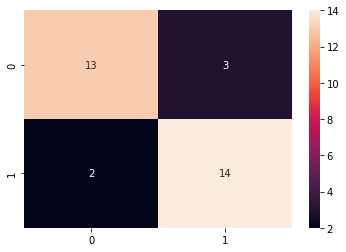

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf = confusion_matrix(y_test_3, pred_class_3)
#print(conf)
sns.heatmap(conf, annot=True, fmt="d")

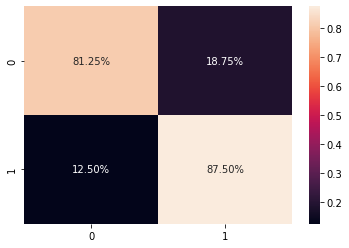

In [ ]:
cm = conf.astype('float') / conf.sum(axis=1)
sns.heatmap(cm, annot=True,
            fmt='.2%')

In [ ]:
from sklearn.metrics import roc_curve

fpr_model_2vs2_exp, tpr_model_2vs2_exp, thresholds_model_2vs2_exp = roc_curve(y_test_3, y_predicted_3[:,1])

In [ ]:
from sklearn.metrics import auc
auc_model_2vs2_exp = auc(fpr_model_2vs2_exp, tpr_model_2vs2_exp)

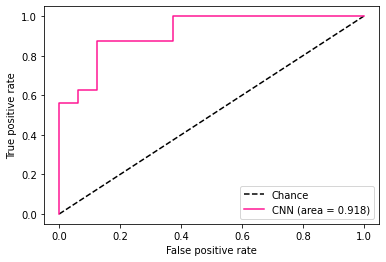

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.plot(fpr_model_2vs2_exp, tpr_model_2vs2_exp, color='deeppink', label='CNN (area = {:.3f})'.format(auc_model_2vs2_exp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend(loc='best')
plt.show()


## Five Classes

mu1

In [ ]:
import os, glob
from collections import defaultdict

dirs = ['/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu1/real', '/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu1/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu1'
for unique_filename, copies in unique_files.items():
  arr= np.stack([genfromtxt(copy, delimiter=',') for copy in copies],axis=0)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)

print(arr.shape)

(71, 22)


mu2

In [ ]:
dirs = ['/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu2/real', '/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu2/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu1'
for unique_filename, copies in unique_files.items():
  arr= np.stack([genfromtxt(copy, delimiter=',') for copy in copies],axis=0)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)

print(arr.shape)

(71, 22)


mu3

In [ ]:
dirs = ['/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu3/real', '/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu3/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu1'
for unique_filename, copies in unique_files.items():
  arr= np.stack([genfromtxt(copy, delimiter=',') for copy in copies],axis=0)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)

print(arr.shape)

(71, 22)


mu4

In [ ]:
dirs = ['/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu4/real', '/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu4/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu1'
for unique_filename, copies in unique_files.items():
  arr= np.stack([genfromtxt(copy, delimiter=',') for copy in copies],axis=0)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)

print(arr.shape)

(71, 22)


mu5

In [ ]:
dirs = ['/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu5/real', '/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu5/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu1'
for unique_filename, copies in unique_files.items():
  arr= np.stack([genfromtxt(copy, delimiter=',') for copy in copies],axis=0)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)

print(arr.shape)

(71, 22)


In [ ]:
new_root_dir_exp = '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp'

In [ ]:
def preprocessing(path,path_mu1, path_mu2, path_mu3,path_mu5):
 imgs_array = []
 label_array = []
 cartelle = [j for j in sorted(os.listdir(path))]

 for folder in cartelle:
   if folder.startswith('eco10-20%'):
     immagini_mu1 = [i for i in sorted(os.listdir(path_mu1))]
     for image in immagini_mu1:
       images = np.load(os.path.join(path_mu1, image))
       images = images.reshape(71,22,1)
       #x = img_to_array(images)
       label_array.append(1)
       imgs_array.append(images) #images are added to a list

   if folder.startswith('eco10-10%'):
     immagini_mu2 = [i for i in sorted(os.listdir(path_mu2))]
     for image in immagini_mu2:
       images = np.load(os.path.join(path_mu2, image))
       images = images.reshape(71,22,1)
       label_array.append(2)
       imgs_array.append(images) #images are added to a list

   if folder.startswith('eco10'):
     immagini_mu3 = [i for i in sorted(os.listdir(path_mu3))]
     for image in immagini_mu3:
       images = np.load(os.path.join(path_mu3, image))
       images = images.reshape(71,22,1)
       label_array.append(3)
       imgs_array.append(images) #images are added to a list


   if folder.startswith('eco30'):
     immagini_mu5 = [i for i in sorted(os.listdir(path_mu5))]
     for image in immagini_mu5:
       images = np.load(os.path.join(path_mu5, image))
       images = images.reshape(71,22,1)
       label_array.append(5)
       imgs_array.append(images) #images are added to a list


 return imgs_array, label_array

In [ ]:
from sklearn.utils import shuffle
path_eco10_20= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10-20%'
path_eco10_10= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10-10%'
path_eco30= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco30'
path_eco10= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10'

#preprocessing and shuffle
new_array_4, new_label_4 = preprocessing(new_root_dir_exp, path_eco10_20, path_eco10_10, path_eco10, path_eco30)
new_array_4, new_label_4 = shuffle(new_array_4,new_label_4, random_state=24) #Random state allows to obtain the same shuffle over time

(71, 22, 1)
3


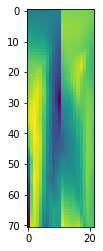

In [ ]:
print(new_array_4[10].shape)
#print(new_label[20].shape)
img=np.reshape(new_array_4[10], (71, 22))
plt.imshow(img)
print(new_label_4[10])


In [ ]:
from sklearn.model_selection import train_test_split

#split in dataset in train-test
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(new_array_4,new_label_4, test_size=0.20, stratify=new_label_4, random_state=42)

#split train in train-valid
Xtrain_4, Xvalid_4, ytrain_4, yvalid_4 = train_test_split(X_train_4,y_train_4, test_size=0.30, stratify=y_train_4, random_state=42)

In [ ]:
print("Dataset Split:")
print(f"Training : {len(Xtrain_4)}")
print(f"Validation : {len(Xvalid_4)}")
print(f"Testing : {len(X_test_4)}")

Dataset Split:
Training : 174
Validation : 75
Testing : 63


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
Xtrain_4 = np.asarray(Xtrain_4)
ytrain_4 = np.asarray(ytrain_4)
ytrain_4 = ytrain_4.reshape(-1, 1)
X_test_4 = np.asarray(X_test_4)
y_test_4 = np.asarray(y_test_4)
y_test_4 = y_test_4.reshape(-1, 1)
yvalid_4 = np.asarray(yvalid_4)
yvalid_4 = yvalid_4.reshape(-1, 1)
Xvalid_4 = np.asarray(Xvalid_4)

encoder = OrdinalEncoder()
ytrain_4 = encoder.fit_transform(ytrain_4)

yvalid_4 = encoder.fit_transform(yvalid_4)

y_test_4 = encoder.fit_transform(y_test_4)


# **Data Augmentation**

In [ ]:
#This is just an example of data augmentation: there are so many functions that you can use!
import tensorflow as tf

def flip_axis(x, axis):
    cp = np.copy(x)
    cp = np.asarray(cp).swapaxes(axis, 0)
    cp = cp[::-1, ...]
    cp = cp.swapaxes(0, axis)
    return cp


def augment_data(dataset, dataset_labels, augementation_factor=1, use_flip_axis=True, use_random_rotation=True, use_random_shear=True, use_random_shift=True, use_random_brightness= True):
    augmented_image = []
    augmented_image_labels = []

    for num in range (0, dataset.shape[0]):
			# original image:
       augmented_image.append(dataset[num])
       augmented_image_labels.append(dataset_labels[num])

       for i in range(0, augementation_factor):

            # flipping
            if use_flip_axis:
                augmented_image.append(flip_axis(dataset[num],1))
                augmented_image_labels.append(dataset_labels[num])

            #random rotation
            #if use_random_rotation:
               # augmented_image.append(tf.keras.preprocessing.image.random_rotation(dataset[num], 40, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
                #augmented_image_labels.append(dataset_labels[num])
            if use_random_rotation:
                augmented_image.append(tf.keras.preprocessing.image.random_rotation(dataset[num], 180, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
                augmented_image_labels.append(dataset_labels[num])
            #random spatial shear
            if use_random_shear:
                augmented_image.append(tf.keras.preprocessing.image.random_shear(dataset[num], 0.2, row_axis=0, col_axis=1, channel_axis=0))
                augmented_image_labels.append(dataset_labels[num])
            #random spatial shift
            if use_random_shift:
                augmented_image.append(tf.keras.preprocessing.image.random_shift(dataset[num], 0.2, 0.2, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
                augmented_image_labels.append(dataset_labels[num])
            if use_random_brightness:
               augmented_image.append(tf.keras.preprocessing.image.random_brightness(dataset[num], [0.2, 0.5]))
               augmented_image_labels.append(dataset_labels[num])

    return np.array(augmented_image), np.array(augmented_image_labels)


In [ ]:
#apply data augmentation
img_augmented_4, label_augmented_4 = augment_data(Xtrain_4, ytrain_4, augementation_factor=1, use_flip_axis=True,
                                                      use_random_rotation=True, use_random_shear=True, use_random_shift=True, use_random_brightness= False)

In [ ]:
print(img_augmented_4.shape)
print(Xtrain_4.shape)

(870, 71, 22, 1)
(174, 71, 22, 1)


[2.]
[2.]


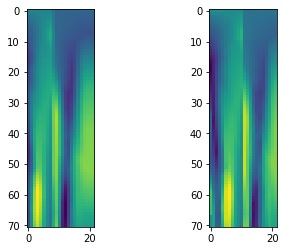

In [ ]:
plt.subplot(121)
img=np.reshape(img_augmented_4[34], (71, 22))
plt.imshow(img)
print(label_augmented_4[34])

plt.subplot(122)
img=np.reshape(img_augmented_4[35], (71, 22))
plt.imshow(img)
print(label_augmented_4[35])

##Model_4

In [ ]:
#model with 71x22 images
from keras.layers import GaussianNoise
def create_model_4():
  model = models.Sequential([

    layers.Conv2D(64, 3, activation='relu', input_shape=(71,22,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(4, activation='softmax'),
  ])
  return model

# Create a basic model instance
model_4 = create_model_4()

# Show a summary of the model. Check the number of trainable parameters
model_4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 69, 20, 64)        640       
                                                                 
 batch_normalization_2 (Batc  (None, 69, 20, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 34, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 21760)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               11141632  
                                                                 
 dropout_3 (Dropout)         (None, 512)              

In [ ]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.

def scheduler(num_epoch, lr):
  if num_epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
num_epochs = 20

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model_4.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model_4.fit(img_augmented_4, label_augmented_4, epochs=num_epochs,  batch_size=12, validation_data=(Xvalid_4, yvalid_4), verbose=1)


Epoch 1/20
73/73 [==============================] - 7s 93ms/step - loss: 1.2169 - accuracy: 0.4414 - val_loss: 1.3350 - val_accuracy: 0.4933
Epoch 2/20
73/73 [==============================] - 6s 85ms/step - loss: 0.9640 - accuracy: 0.6138 - val_loss: 1.2985 - val_accuracy: 0.4933
Epoch 3/20
73/73 [==============================] - 6s 86ms/step - loss: 0.8605 - accuracy: 0.6667 - val_loss: 1.2554 - val_accuracy: 0.6533
Epoch 4/20
73/73 [==============================] - 6s 85ms/step - loss: 0.7866 - accuracy: 0.6828 - val_loss: 1.1833 - val_accuracy: 0.7467
Epoch 5/20
73/73 [==============================] - 6s 86ms/step - loss: 0.7218 - accuracy: 0.7379 - val_loss: 1.1002 - val_accuracy: 0.7867
Epoch 6/20
73/73 [==============================] - 6s 86ms/step - loss: 0.6604 - accuracy: 0.7586 - val_loss: 0.9779 - val_accuracy: 0.7867
Epoch 7/20
73/73 [==============================] - 6s 86ms/step - loss: 0.6460 - accuracy: 0.7736 - val_loss: 0.8411 - val_accuracy: 0.7867
Epoch 8/20
73

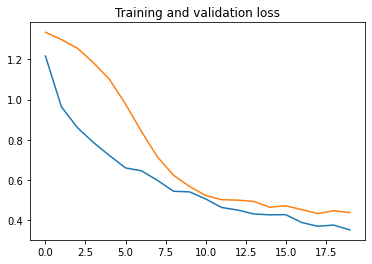

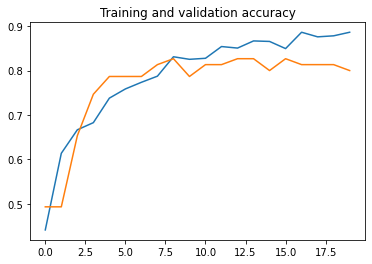

In [ ]:
import matplotlib.pyplot as plt

epochs = num_epochs
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")

              precision    recall  f1-score   support

         0.0       0.64      0.64      0.64        11
         1.0       0.82      0.90      0.86        10
         2.0       0.86      0.94      0.90        32
         3.0       1.00      0.60      0.75        10

    accuracy                           0.83        63
   macro avg       0.83      0.77      0.78        63
weighted avg       0.84      0.83      0.82        63

accuracy: 0.8253968253968254
2
0


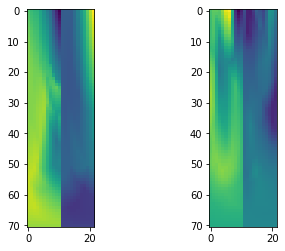

In [ ]:
#results:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#y_pred = model.predict_classes(X_test)
y_pred_4= np.argmax(model_4.predict(X_test_4),1)


print(sklearn.metrics.classification_report(y_test_4, y_pred_4))
a = accuracy_score(y_test_4, y_pred_4)
print("accuracy:",a)
plt.subplot(121)
img=np.reshape(X_test_4[20], (71, 22))
plt.imshow(img)

print(y_pred_4[20])
plt.subplot(122)
img_1=np.reshape(X_test_4[4], (71, 22))
plt.imshow(img_1)
print(y_pred_4[4])

In [ ]:
y_predicted_4 = model_4.predict(X_test_4) #predict will return the scores of the model and predict_class will return the class of your predictions. Although it seems similar there are some differences:
pred_class_4 = np.argmax(y_predicted_4, axis=1)  #argmax tra le colonne (axis =1)


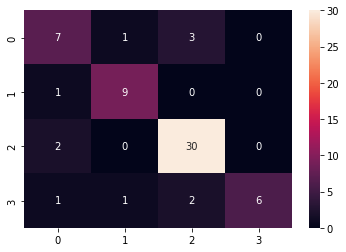

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf = confusion_matrix(y_test_4, pred_class_4)
#print(conf)
sns.heatmap(conf, annot=True, fmt="d")

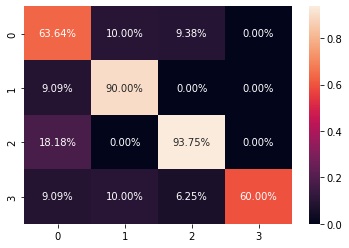

In [ ]:
cm = conf.astype('float') / conf.sum(axis=1)
sns.heatmap(cm, annot=True,
            fmt='.2%')